In [2]:
%load_ext autoreload
%autoreload 2
import time, array, random, copy, math
from collections import Counter
import numpy as np
import logging
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as a3
from matplotlib.path import Path
import matplotlib.patches as patches

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] ='\\usepackage{libertine}\n\\usepackage[utf8]{inputenc}'

import seaborn
seaborn.set(style='whitegrid')
seaborn.set_context('notebook')
import random
import PreEmo

from selection import *
from deap import algorithms, base, benchmarks, tools, creator

In [3]:
def init_logging(log_file=None, append=False, console_loglevel=logging.INFO):
    if log_file is not None:
        if append:
            filemode_val = 'a'
        else:
            filemode_val = 'w'
        logging.basicConfig(level=logging.DEBUG,
                            format="%(asctime)s %(levelname)s %(name)s %(message)s",
                            datefmt='%d-%m %H:%M',
                            filename=log_file,
                            filemode=filemode_val)
    else:
        # define a Handler which writes INFO messages or higher to the sys.stderr
        console = logging.StreamHandler()
        console.setLevel(console_loglevel)
        # set a format which is simpler for console use
        formatter = logging.Formatter("%(message)s")
        console.setFormatter(formatter)
        # add the handler to the root logger
        logging.getLogger('').addHandler(console)
    global LOG
    LOG = logging.getLogger(__name__) 

In [4]:
'''
# Import Data
df = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/mpg_ggplot2.csv")

# Create Fig and gridspec
fig = plt.figure(figsize=(16, 10), dpi= 80)
grid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)

# Define the axes
ax_main = fig.add_subplot(grid[:-1, :-1])
ax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])
ax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])

# Scatterplot on main ax
ax_main.scatter('displ', 'hwy', s=df.cty*5, c=df.manufacturer.astype('category').cat.codes, alpha=.9, data=df, cmap="Set1", edgecolors='black', linewidths=.5)

# Add a graph in each part
sns.boxplot(df.hwy, ax=ax_right, orient="v")
sns.boxplot(df.displ, ax=ax_bottom, orient="h")

# Decorations ------------------
# Remove x axis name for the boxplot
ax_bottom.set(xlabel='')
ax_right.set(ylabel='')

# Main Title, Xlabel and YLabel
ax_main.set(title='Scatterplot with Histograms \n displ vs hwy', xlabel='displ', ylabel='hwy')

# Set font size of different components
ax_main.title.set_fontsize(20)
for item in ([ax_main.xaxis.label, ax_main.yaxis.label] + ax_main.get_xticklabels() + ax_main.get_yticklabels()):
    item.set_fontsize(14)

plt.show()
'''

'\n# Import Data\ndf = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/mpg_ggplot2.csv")\n\n# Create Fig and gridspec\nfig = plt.figure(figsize=(16, 10), dpi= 80)\ngrid = plt.GridSpec(4, 4, hspace=0.5, wspace=0.2)\n\n# Define the axes\nax_main = fig.add_subplot(grid[:-1, :-1])\nax_right = fig.add_subplot(grid[:-1, -1], xticklabels=[], yticklabels=[])\nax_bottom = fig.add_subplot(grid[-1, 0:-1], xticklabels=[], yticklabels=[])\n\n# Scatterplot on main ax\nax_main.scatter(\'displ\', \'hwy\', s=df.cty*5, c=df.manufacturer.astype(\'category\').cat.codes, alpha=.9, data=df, cmap="Set1", edgecolors=\'black\', linewidths=.5)\n\n# Add a graph in each part\nsns.boxplot(df.hwy, ax=ax_right, orient="v")\nsns.boxplot(df.displ, ax=ax_bottom, orient="h")\n\n# Decorations ------------------\n# Remove x axis name for the boxplot\nax_bottom.set(xlabel=\'\')\nax_right.set(ylabel=\'\')\n\n# Main Title, Xlabel and YLabel\nax_main.set(title=\'Scatterplot with Histograms \n displ vs h

Assuming given user Input
Duration = 5 weeks
Budget = 4000
Unwanted Regions = [Afghanistan, Pacific]
Preference activities = [hiking, beach, watersports, culinary, entertainment]
Preferred Travel Months = [apr, may, jun]

### Now pre-initialization

First we use the similarity metric to get a ranking of regions
$$
\begin{align*}
sim_{feature} (f_q, f_c) = 1 - \frac{\lvert f_q - f_c \rvert} {max(f_q , f_c)}
\end{align*}
$$

$$
\begin{align*}

similarity (q, c) = \frac{\sum_{i=1}^{n} w_i * sim_i(q_i, c_i)} {\sum_{i=1}^{n} w_i}
\end{align*}
$$

similarity current region and given input
all possible preferences is n
f_q = 1
f_c = actual score for preference i



We do a Max Min Normalization of the scores 

$$
\begin{align*}
X_{ij} = \frac{X_{ij} - X_j^{min}}{X_j^{max}-X_j^{min}}
\end{align*}
$$

In [5]:
user_input,considered_cats, start_df = PreEmo.get_start_df()


In [6]:
start_df.head()

,Region,category,cat_score,childRegions
126,Antarctica and South Atlantic,Safety from crime,0.50,"Antarctica and South Atlantic, Argentina, Boli..."
128,Antarctica and South Atlantic,beach,0.75,"Antarctica and South Atlantic, Argentina, Boli..."
129,Antarctica and South Atlantic,watersports,0.25,"Antarctica and South Atlantic, Argentina, Boli..."
130,Antarctica and South Atlantic,entertainment,0.75,"Antarctica and South Atlantic, Argentina, Boli..."
131,Antarctica and South Atlantic,culinary,0.75,"Antarctica and South Atlantic, Argentina, Boli..."


In [7]:
start_df.loc[start_df['category'].isin(considered_cats), 'cat_score'].describe()

count    342.000000
mean       0.475146
std        0.221887
min        0.000000
25%        0.250000
50%        0.500000
75%        0.750000
max        1.000000
Name: cat_score, dtype: float64

In [8]:
regions = start_df.Region.unique()


In [9]:
considered_cats

['hiking',
 'beach',
 'watersports',
 'culinary',
 'entertainment',
 'apr',
 'may',
 'jun',
 'Safety from crime']

In [10]:
def data_selection_v1():
    data_set = list()
    strategy_set = list()
    strategy_cats = [cat for cat in start_df.category.unique() if cat not in considered_cats]
    i = 0
    data_index_info = None
    strategy_index_info = None
    for _, group in start_df.groupby('Region'):
        if i == 0:
            temp = group.loc[group['category'].isin(considered_cats), ['category','cat_score']].set_index('category').loc[:, 'cat_score'].index.tolist() 
            data_index_info = {x : temp[x] for x in range(0, len(temp)) }
            temp = group.loc[group['category'].isin(strategy_cats), ['Region','category','cat_score']].set_index('category').loc[:, ['Region', 'cat_score']].index.tolist() 
            strategy_index_info = {x : temp[x] for x in range(0, len(temp)) }
            i+=1
        curr = group.loc[group['category'].isin(considered_cats), 'cat_score'].values.tolist()
        data_set.append(curr)
        curr = group.loc[group['category'].isin(strategy_cats), ['Region', 'cat_score']].values.tolist()
        strategy_set.append(curr)
    return data_set, strategy_set, data_index_info, strategy_index_info 

In [11]:
def data_selection_v2():
    data_set = list()
    strategy_set = list()
    #strategy_cats = [cat for cat in start_df.category.unique() if cat not in considered_cats]
    data_index_info = dict()
    strategy_index_info = dict()
    cat_data_index = 0
    cat_strategy_index = 0
    region_index_info = None
    region_groups = dict()
    for cat, group in start_df.groupby('category'):
        if cat in considered_cats:
            data_index_info[cat] = cat_data_index
            curr = group.loc[:, 'cat_score'].values.tolist()
            data_set.append(curr)
            cat_data_index +=1
        else:
            strategy_index_info[cat] = cat_strategy_index
            curr = group.loc[:, 'cat_score'].values.tolist()
            strategy_set.append(curr)
            cat_strategy_index += 1
        if region_index_info is None:
            region_index_info = dict(enumerate(group.Region.unique()))
    
    for region in set(start_df.Region):
        if region not in region_groups.keys():
            region_groups[region] = set()
        region_groups[region].update(set(start_df.loc[(start_df['childRegions'].str.contains(region, case=False)), 'childRegions']))
    return data_set, strategy_set, data_index_info, strategy_index_info, region_index_info, region_groups 

In [12]:
#data_set = list(map(list, zip(*data_set)))
data_set, strategy_set, data_index_info, strategy_index_info, region_index_info, region_groups = data_selection_v2()

C:\Users\suzzy\anaconda3\envs\vfeat\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


Implementing the Moop Problem

$$
\begin{align*}maximize \qquad  &z_k(x) = \sum_{i=1}^n x_i\ s_{ik}, \hspace{1cm} k = 1,...,p \\
    subject \ to \qquad &\sum_{i=1}^n x_i d_i  \leq D \\
    &\sum_{i=1}^n x_i\ b_i \leq B \\
    &\sum_{j \in N} x_{ij} \geq 1 \\ 
    &g_{il}(x_i) \leq \delta,  \hspace{1cm} \forall \ 1 \leq i < l \leq n  \\
    x_i \in \{0,1\}, \qquad &\forall \ 1 \leq i \leq n
\end{align*}
$$

In [13]:
#toolbox.strategy_indexInfo
def max_possible_mixed_utility(weekstoupper, weekstolower):
    sumlist = []
    curr_max = -1
    for i, score in enumerate(weekstolower):
        indx = {'l': [i], 'u':[n for (n,x) in enumerate(weekstoupper) if n!=i]}
        result = score + np.sum([x for n,x in enumerate(weekstoupper) if n!=i] )
        if result > curr_max:
            sumlist = [result, indx]
            curr_max = result
    for i, score in enumerate(weekstoupper):
        indx = {'u': [i], 'l':[n for (n,x) in enumerate(weekstolower) if n!=i]}
        result = score + np.sum([x for (n,x) in enumerate(weekstolower) if n!=i] )
        if result > curr_max:
            sumlist = [result, indx]
            curr_max = result
    return sumlist


    
   

In [14]:
def feasible(individual):
    individual_strategy = individual.strategy
    feasible = False
    info_region_duration = dict() # {'2': 4}
    info_region_budget = dict()
    weeks_to_upper = individual_strategy[toolbox.strategy_indexInfo['Weeks to Upper Quantile']]
    weeks_to_lower = individual_strategy[toolbox.strategy_indexInfo['Weeks to Lower Quantile']]
    average_cost_pair = individual_strategy[toolbox.strategy_indexInfo['average weekly cost']]
    region_combo = [toolbox.region_indexInfo[pos] for pos in individual.itemPositions]
    logging.info(f'Starting Feasibility Test of Item combination: {individual.itemPositions}, BUDGET: {BUDGET}, DURATION: {DURATION}' )
    #check bounds constraint to ensure atleast one region is selected
    if individual.binarySelection.count(1) == 0:
        logging.info('Infeasible: Trip does not contain atleast a region')
        return feasible 

    #check constraint 1 -> duration
    sum_lower = np.sum(weeks_to_lower)
    sum_upper = np.sum(weeks_to_upper)
    if (sum_upper > DURATION) :
        # failed-> check with mix of upper and lower
        mixed = max_possible_mixed_utility(weeks_to_upper, weeks_to_lower)
        if(mixed[0] > sum_lower and mixed[0] <= DURATION):
            info_region_duration = {individual.itemPositions[pos]: weeks_to_lower[pos] for pos in mixed[1]['l'] if individual.binarySelection[pos] == 1}
            info_region_duration.update({individual.itemPositions[pos]: weeks_to_upper[pos] for pos in mixed[1]['u'] if individual.binarySelection[pos] == 1} )
        elif(sum_lower < DURATION):
            info_region_duration = {individual.itemPositions[x]: y for x,y in enumerate(weeks_to_lower) if individual.binarySelection[x] == 1 }
    elif (sum_upper <= DURATION):
        info_region_duration = {individual.itemPositions[x]: y for x,y in enumerate(weeks_to_upper) if individual.binarySelection[x] == 1}
    else:
        logging.info('Infeasible: Duration constraint not fufilled')
        return feasible

    #check constraint 2 -> budget
    if ((np.sum(average_cost_pair) * sum(info_region_duration.values()) ) <= BUDGET):
        info_region_budget = {individual.itemPositions[x]: y for x,y in enumerate(average_cost_pair) if individual.binarySelection[x] == 1 }
    else:
        logging.info('Infeasible: Budget constraints not fufilled for utility maximizing duration')
        return feasible
    #check constraint 3 -> score greater 0 in for each category in each region
    unfulfilledCat = [True for x, cat_scores in enumerate(individual) if cat_scores.count(0.0) == len(cat_scores)]
    if len(unfulfilledCat) > 0:
        logging.info('Infeasible: Atleast one input category not fulfilled')
        return  feasible
    #check constraint 4 -> combination of regions each belong to same group
    region_combo = [toolbox.region_indexInfo[pos] for i, pos in enumerate(individual.itemPositions) if individual.binarySelection[i] == 1]
    unfulfilledCat = []
    for region in region_combo:
        unfulfilledCat.extend([True for x in region_combo if (x != region) and (region not in toolbox.region_groups[x])])
    if len(unfulfilledCat) == 0:
        logging.info('Item combination is feasible')
        feasible = True
        individual.feasibilityInfo = [info_region_duration, info_region_budget]
    
    return feasible

    

In [24]:
init_logging('logs/testlog.log', append=False)
test = [] 
for ind in population:
    test.append(feasible(ind))

In [15]:
POP_SIZE = 1000
NDIM = 2   #Number of objectives which will also be size of one individual
NUM_REGIONS = int(start_df.Region.nunique()) 
NUM_VARIABLES = len(considered_cats)
BOUNDS_LOW, BOUNDS_UP = 0, 1
BUDGET = user_input['Budget']
DURATION = user_input['Duration']

In [16]:

def generateES(icls, scls, infocls, fcls, bcls, data_set, strategy_set):
    indx = random.sample(range(NUM_REGIONS), NDIM)
    binaryWeights = np.random.randint(2, size=NDIM)
    temp_data = np.array(data_set)
    temp_strategy = np.array(strategy_set)
    binaryWeighted = np.multiply([list(row[indx]) for row in temp_data], binaryWeights).tolist()
    ind = icls(binaryWeighted)
    binaryWeighted = np.multiply([list(row[indx]) for row in temp_strategy], binaryWeights).tolist()
    ind.strategy = scls(binaryWeighted)
    ind.itemPositions = infocls(indx)
    ind.feasibilityInfo = fcls(list())
    ind.binarySelection = bcls(list(binaryWeights))
    return ind


In [17]:
#evaluate function encompases the objective function
def evaluate(individual):
    regional_data = list(map(list, zip(*individual)))
    scores = [np.sum(region_scores) for region_scores in regional_data]
    return list(np.multiply(scores, individual.binarySelection))

In [18]:
def evaluate_with_penalty(individual, population):
    pass

In [19]:
toolbox = base.Toolbox()
toolbox.region_groups = region_groups
toolbox.data_indexInfo = data_index_info
toolbox.strategy_indexInfo = strategy_index_info
toolbox.region_indexInfo = region_index_info
toolbox.max_gen = 200 # max number of iteration
toolbox.mut_prob = 1/NDIM
toolbox.cross_prob = 0.3
creator.create("FitnessMoop", base.Fitness, weights=(1.0, )*NDIM)
creator.create("Individual", list, fitness=creator.FitnessMoop)
creator.create("Strategy", list)
creator.create("ItemPositions", list )
creator.create("FeasibilityInfo", list)
creator.create("BinarySelectionPositions", list)

In [20]:
toolbox.register("individual", generateES, creator.Individual, creator.Strategy, creator.ItemPositions, creator.FeasibilityInfo, creator.BinarySelectionPositions, data_set, strategy_set)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
#population = toolbox.population(n=POP_SIZE)

In [21]:
toolbox.register("mate", tools.cxSimulatedBinaryBounded, low=BOUNDS_LOW, up=BOUNDS_UP, eta=20.0)
toolbox.register("mutate", tools.mutPolynomialBounded, low=BOUNDS_LOW, up=BOUNDS_UP, eta=20.0, indpb=1.0/NDIM)
toolbox.register("select", sel_nsga_iii)
toolbox.register("evaluate", evaluate)


In [22]:
population = toolbox.population(n=POP_SIZE)

In [23]:
fitnesses = toolbox.map(toolbox.evaluate, population)
for ind, fit in zip(population, fitnesses):
    ind.fitness.values = fit

In [ ]:
ref_points = tools.uniform_reference_points(NDIM, p=4)

In [80]:
dominated = [ind for ind in population if tools.emo.isDominated(a_given_individual.fitness.wvalues, ind.fitness.wvalues)]
dominators = [ind for ind in population if tools.emo.isDominated(ind.fitness.wvalues, a_given_individual.fitness.wvalues)]
others = [ind for ind in population if not ind in dominated and not ind in dominators]

In [73]:
def plot_dent():
    'Plots the points in decision and objective spaces.'
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    for ind in dominators: plt.plot(ind[0], ind[1], 'r.')
    for ind in dominated: plt.plot(ind[0], ind[1], 'g.')
    for ind in others: plt.plot(ind[0], ind[1], 'k.', ms=3)
    plt.plot(a_given_individual[0], a_given_individual[1], 'bo', ms=6);
    plt.xlabel('$x_1$');plt.ylabel('$x_2$');
    plt.title('Decision space');
    plt.subplot(1,2,2)
    for ind in dominators: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'r.', alpha=0.7)
    for ind in dominated: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'g.', alpha=0.7)
    for ind in others: plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', alpha=0.7, ms=3)
    plt.plot(a_given_individual.fitness.values[0], a_given_individual.fitness.values[1], 'bo', ms=6);
    plt.xlabel('$f_1(\mathbf{x})$');plt.ylabel('$f_2(\mathbf{x})$');
    plt.xlim((0.5,3.6));plt.ylim((0.5,3.6));
    plt.title('Objective space');
    plt.tight_layout()

In [84]:

non_dom = tools.sortNondominated(population, k=len(population), first_front_only=True)[0]


Text(0.5, 1.0, 'Pareto-optimal front')

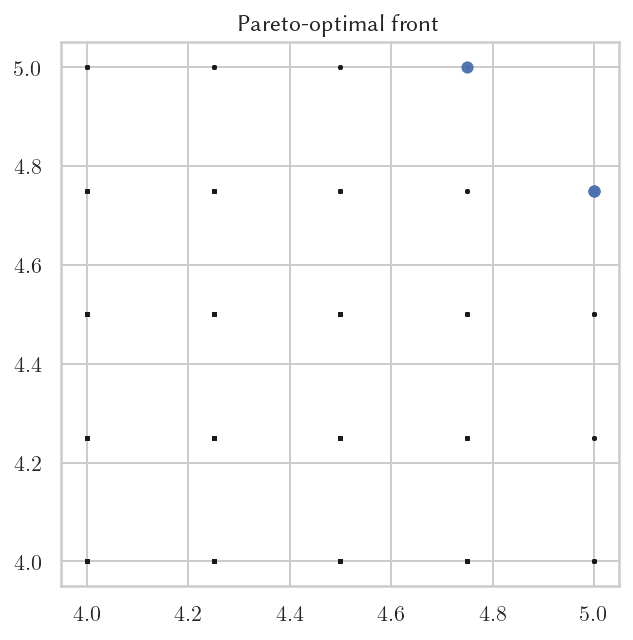

In [85]:
plt.figure(figsize=(5,5))
for ind in population:
    plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'k.', ms=3, alpha=0.5)
for ind in non_dom:
    plt.plot(ind.fitness.values[0], ind.fitness.values[1], 'bo', alpha=0.74, ms=5)
plt.title('Pareto-optimal front')

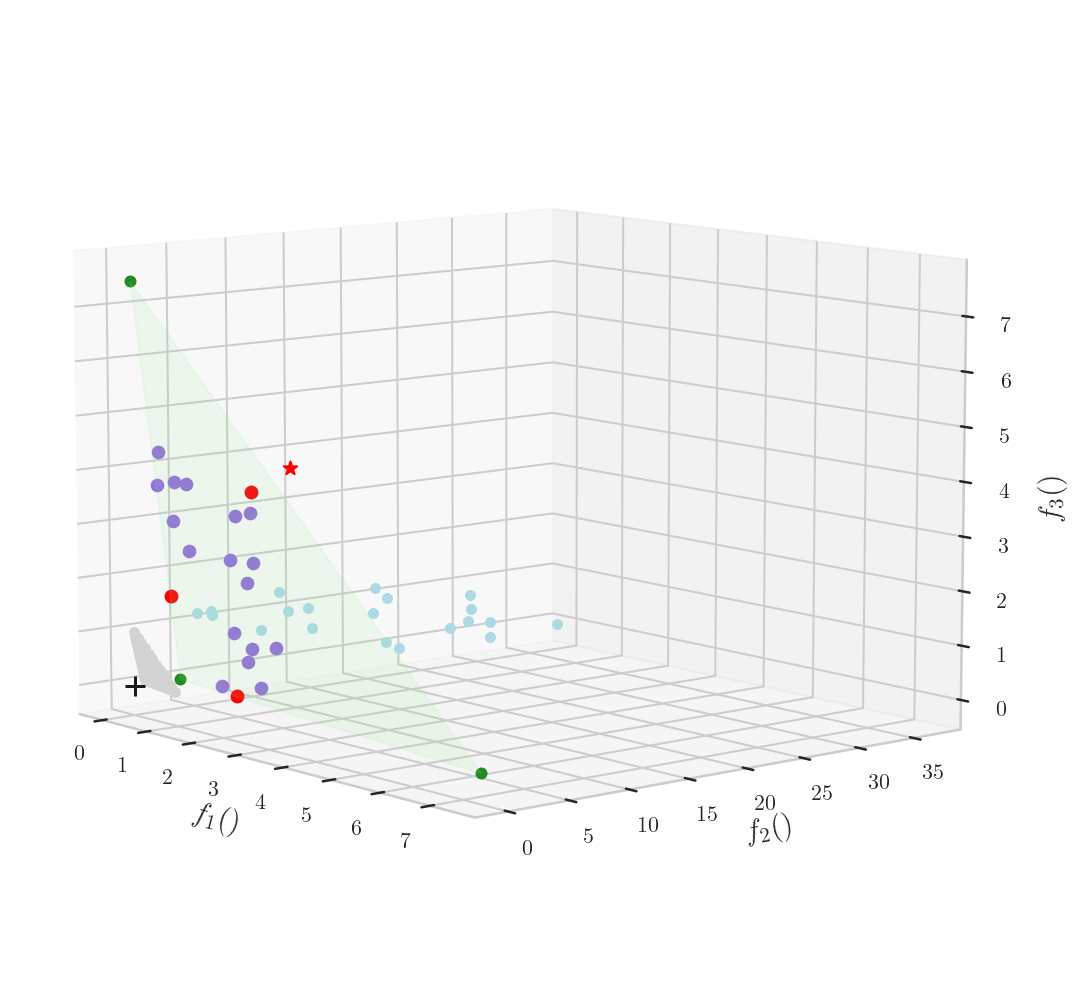

In [248]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin (black + sign)
ax.scatter(0,0,0, c='k', marker='+', s=100)

# the population (purple)
for ind in pop:
    ax.scatter(ind.fitness.values[0],
               ind.fitness.values[1], 
               ind.fitness.values[2], 
                c='mediumpurple',
               s=NUM_VARIABLES, marker='o')

# ideal point (red star)
ideal_point = selection.find_ideal_point_modified(pop)
ax.scatter(ideal_point[0], ideal_point[1], ideal_point[2],
           s=50, marker='*',  c='red')

# extreme points marked (red)
extremes = selection.find_extreme_points_modified(pop)
for i,ex in enumerate(extremes):
    ax.scatter(ex.fitness.values[0],
               ex.fitness.values[1], 
               ex.fitness.values[2], s=NUM_VARIABLES, c='red', marker='o')

# intercepts (in green)
intercepts = selection.construct_hyperplane(pop, extremes)
verts = [(intercepts[0], 0, 0), (0, intercepts[1], 0), (0, 0, intercepts[2])]

for vert in verts:
    ax.scatter(vert[0], vert[1], vert[2], c='forestgreen', s=POP_SIZE, marker='.')
    
tri = a3.art3d.Poly3DCollection([verts])
tri.set_color('lightgreen')
tri.set_alpha(0.11)
tri.set_edgecolor('lightgreen')
ax.add_collection3d(tri)

# normalized objectives (light blue)
selection.normalize_objectives(pop, intercepts, ideal_point)

for ind in pop:
    ax.scatter(ind.fitness.normalized_values[0], 
               ind.fitness.normalized_values[1], 
               ind.fitness.normalized_values[2],  marker='o', c='lightblue')

# reference points (gray)
rps = selection.generate_reference_points(3)
for rp in rps:
    ax.scatter(rp[0], rp[1], rp[2], marker='o',  c='lightgray')

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=9, azim=-40)
plt.autoscale(tight=True)

In [245]:

selection.associate(pop, rps)

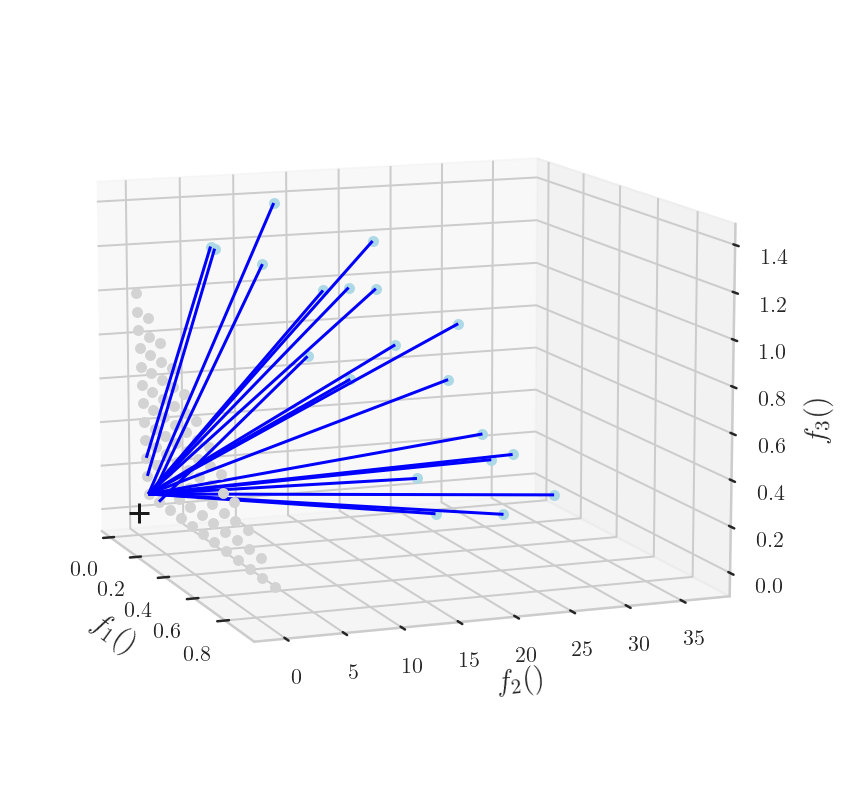

In [246]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111, projection='3d')

# the coordinate origin
ax.scatter(0,0,0, c='k', marker='+', s=100)

for rp in rps:
    ax.scatter(rp[0], rp[1], rp[2], marker='o', c='lightgray')

pairs = []
for ind in pop:
    ax.scatter(ind.fitness.normalized_values[0], 
               ind.fitness.normalized_values[1], 
               ind.fitness.normalized_values[2],  marker='o', c='lightblue')
    pairs += [(ind.fitness.normalized_values, ind.reference_point)]

lin = a3.art3d.Line3DCollection(pairs)
lin.set_color('blue')
ax.add_collection3d(lin)

# final figure details   
ax.set_xlabel('$f_1()$', fontsize=15)
ax.set_ylabel('$f_2()$', fontsize=15)
ax.set_zlabel('$f_3()$', fontsize=15)
ax.view_init(elev=11, azim=-21)
plt.autoscale(tight=True)